#AIM: Multivariate Time Series Anomaly Detection with TS2Vec and Dynamic Thresholding

# Multivariate Time Series Anomaly Detection using TS2Vec

This project focuses on detecting anomalies in multivariate system performance data—such as CPU, Memory, Disk, and other related metrics—by learning deep representations of individual time series. The approach uses TS2Vec, a self-supervised time series embedding model, to capture the temporal patterns of each metric and identify unusual behavior over time.

## Key Components

### 1. Data Simulation and Preprocessing

- A synthetic dataset is generated with injected anomalies at specified timestamps.
- Data is normalized using MinMaxScaler to bring all metric values into a common scale.
- A time-indexed DataFrame is created with ten system performance metrics.

### 2. Anomaly Score Generation

- Anomaly scores are computed for each timestamp using a chosen model or a custom scoring method.
- Dynamic thresholding is applied using a rolling window and z-score approach to flag anomalies based on temporal context.

### 3. TS2Vec Encoding for Correlation Analysis

- Each performance metric is treated as a univariate time series.
- TS2Vec is used to encode each metric individually, capturing temporal dependencies and trends.
- The resulting embeddings can be compared or clustered to analyze correlations, detect concept drift, or support multivariate anomaly detection.

## Goals

- Identify anomalies with high temporal sensitivity.
- Learn meaningful representations of time series without requiring labels.
- Understand correlations and divergences between system metrics using learned embeddings.


#### Main sources : https://arxiv.org/abs/2106.10466
#### github reference : https://github.com/zhihanyue/ts2vec

# Initial example of the kind of data we will be working with

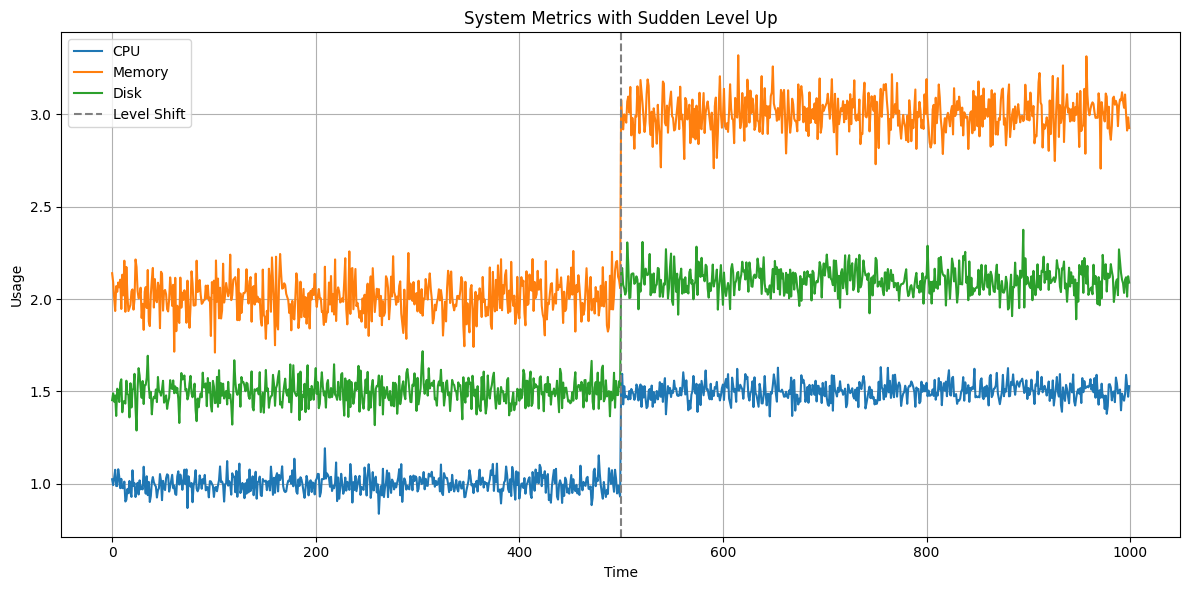

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to inject sudden level shift
def inject_level_shift(series, index, shift=0.8, direction='up'):
    delta = shift if direction == 'up' else -shift
    series[index:] += delta
    return series

# Step 1: Generate base time series data
np.random.seed(42)
n = 1000
time = np.arange(n)

cpu = np.random.normal(loc=1.0, scale=0.05, size=n)
memory = np.random.normal(loc=2.0, scale=0.1, size=n)
disk = np.random.normal(loc=1.5, scale=0.07, size=n)

# Step 2: Inject level shift at index 500
cpu = inject_level_shift(cpu, index=500, shift=0.5)
memory = inject_level_shift(memory, index=500, shift=1.0)
disk = inject_level_shift(disk, index=500, shift=0.6)

# Step 3: Create DataFrame
df = pd.DataFrame({
    'Time': time,
    'CPU': cpu,
    'Memory': memory,
    'Disk': disk
})

# Step 4: Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['CPU'], label='CPU')
plt.plot(df['Time'], df['Memory'], label='Memory')
plt.plot(df['Time'], df['Disk'], label='Disk')
plt.axvline(x=500, color='gray', linestyle='--', label='Level Shift')
plt.title('System Metrics with Sudden Level Up')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## DATASETS WITH LEVEL UP SHIFT AND LEVEL DOWN SHIFT

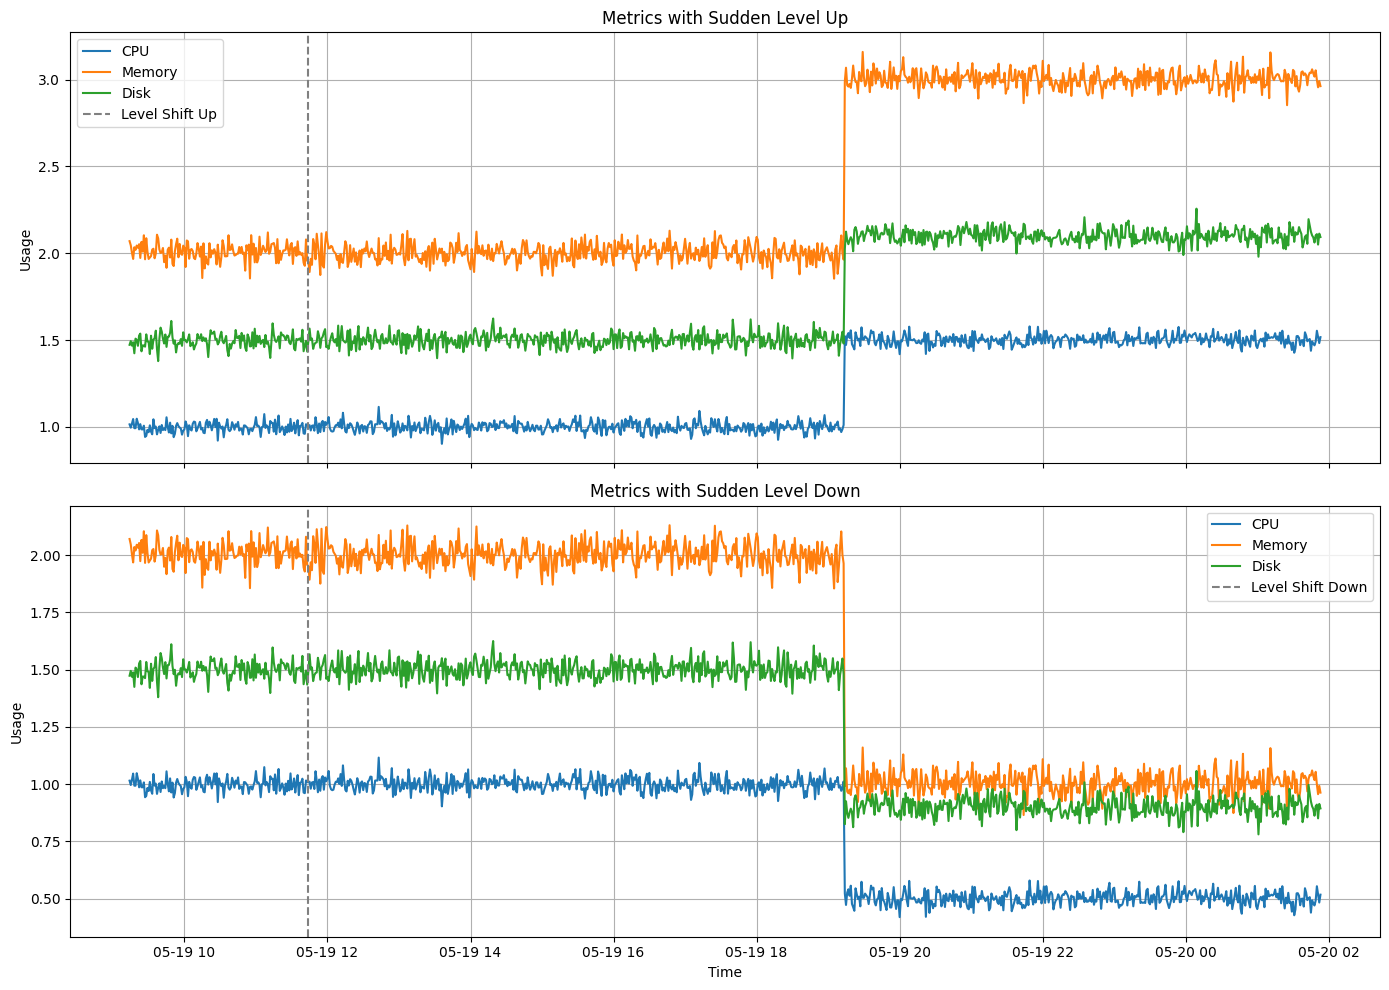

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load both CSVs, parsing the Time column as datetime
df_up   = pd.read_csv('system_metrics_shift_up_final.csv', parse_dates=['Time']) #shift up data
df_down = pd.read_csv('system_metrics_shift_down_final.csv',    parse_dates=['Time'])

# 2. Set up a figure with two subplots (one for upward shift, one for downward)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# 3. Plot the “level up” data
axes[0].plot(df_up['Time'], df_up['CPU'],    label='CPU')
axes[0].plot(df_up['Time'], df_up['Memory'], label='Memory')
axes[0].plot(df_up['Time'], df_up['Disk'],   label='Disk')
axes[0].axvline(x=df_up['Time'].iloc[150], linestyle='--', color='gray',
                label='Level Shift Up')
axes[0].set_title('Metrics with Sudden Level Up')
axes[0].set_ylabel('Usage')
axes[0].legend()
axes[0].grid(True)

# 4. Plot the “level down” data
axes[1].plot(df_down['Time'], df_down['CPU'],    label='CPU')
axes[1].plot(df_down['Time'], df_down['Memory'], label='Memory')
axes[1].plot(df_down['Time'], df_down['Disk'],   label='Disk')
axes[1].axvline(x=df_down['Time'].iloc[150], linestyle='--', color='gray',
                label='Level Shift Down')
axes[1].set_title('Metrics with Sudden Level Down')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Usage')
axes[1].legend()
axes[1].grid(True)

# 5. Adjust layout and show
plt.tight_layout()
plt.show()


## APPLYING TS2VEC ON LEVEL UP DATA

In [ ]:
!pip install ts2vec

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ts2vec import TS2Vec
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv('system_metrics_shift_up_final.csv', parse_dates=['Time'], index_col='Time')

# Visualize first few rows
print(df.head())

# Extract data values
data = df[['CPU', 'Memory', 'Disk']].values  # shape: (1000, 3)

# Normalize
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Get shapes
T, D = data.shape
print(f"Time steps: {T}, Features: {D}")


                          CPU    Memory      Disk
Time                                             
2025-05-19 09:14:00  1.014901  2.069968  1.472993
2025-05-19 09:15:00  0.995852  2.046232  1.494219
2025-05-19 09:16:00  1.019431  2.002982  1.468303
2025-05-19 09:17:00  1.045691  1.967653  1.487682
2025-05-19 09:18:00  0.992975  2.034911  1.424255
Time steps: 1000, Features: 3


In [ ]:
train_ratio = 0.5
T = data.shape[0]
split_idx = int(T * train_ratio)

train_data = data[:split_idx]
test_data = data[split_idx:]

train_data_3d = train_data.reshape(1,-1, data.shape[1])
test_data_3d = train_data.reshape(1,-1, data.shape[1])

In [ ]:
# Reshape to 3D input for TS2Vec: (batch_size, time_steps, dimensions)
model = TS2Vec(input_dims=D, output_dims=320,device = 'cuda')
model.fit(train_data_3d, verbose=True, n_epochs = 800)
print("model fit on data")

Epoch #0: loss=3.5269775390625
Epoch #1: loss=2.2971794605255127
Epoch #2: loss=1.9662519693374634
Epoch #3: loss=1.6577935218811035
Epoch #4: loss=1.9002151489257812
Epoch #5: loss=1.8506819009780884
Epoch #6: loss=1.4822758436203003
Epoch #7: loss=1.388692855834961
Epoch #8: loss=1.7487032413482666
Epoch #9: loss=1.528181552886963
Epoch #10: loss=1.5118337869644165
Epoch #11: loss=1.7060999870300293
Epoch #12: loss=1.6869186162948608
Epoch #13: loss=1.37894868850708
Epoch #14: loss=1.7335841655731201
Epoch #15: loss=1.1198670864105225
Epoch #16: loss=0.9001046419143677
Epoch #17: loss=1.524070382118225
Epoch #18: loss=1.5212619304656982
Epoch #19: loss=1.5356202125549316
Epoch #20: loss=1.8389097452163696
Epoch #21: loss=1.488750696182251
Epoch #22: loss=1.7494984865188599
Epoch #23: loss=1.8483175039291382
Epoch #24: loss=1.115316390991211
Epoch #25: loss=1.321036696434021
Epoch #26: loss=1.6811785697937012
Epoch #27: loss=1.7143220901489258
Epoch #28: loss=1.6612807512283325
Epoch 

In [ ]:
# Function to get masked and unmasked representations
def get_anomaly_scores(ts2vec_model, data_to_score):
    """
    Calculates anomaly scores based on the TS2Vec paper's method:
    S_t = ||R(x_{<=t}) - R(x_{<t})||_2.

    R(x_{<=t}) is the "unmasked" representation of data up to time t.
    R(x_{<t}) is the "masked" representation (data up to time t-1), approximated
    by R(x_{<=t-1}).

    Args:
        ts2vec_model: The trained TS2Vec model.
        data_to_score: A NumPy array of shape (num_timesteps, num_features)
                       or (1, num_timesteps, num_features).

    Returns:
        A NumPy array of raw anomaly scores, shape (num_timesteps,).
    """
    if data_to_score.ndim == 1: # Univariate series (T,)
        # Reshape to (num_timesteps, 1) to be treated as a feature.
        data_to_score = data_to_score.reshape(-1, 1)

    if data_to_score.ndim == 2: # Expected shape: (num_timesteps, num_features)
        num_timesteps, num_features = data_to_score.shape
        # Reshape to (1, num_timesteps, num_features) for the model.encode method
        data_input = data_to_score.reshape(1, num_timesteps, num_features)
    elif data_to_score.ndim == 3: # Expected shape: (1, num_timesteps, num_features)
        if data_to_score.shape[0] != 1:
            raise ValueError("If data_to_score is 3D, its first dimension (batch_size) must be 1.")
        data_input = data_to_score
        _, num_timesteps, num_features = data_input.shape # num_features is model.input_dims
    else:
        raise ValueError("Input data_to_score must be 2D (num_timesteps, num_features) or 3D (1, num_timesteps, num_features)")

    if num_timesteps == 0:
        return np.array([])

    # 1. Get Unmasked Embeddings: R(x_{<=t}) for each t
    # model.encode with causal=True and sliding_length=None gives prefix encodings.
    # Output shape from encode: (batch_size, num_timesteps, emb_dim)
    unmasked_embeddings_batch = ts2vec_model.encode(
        data_input,
        causal=True,
        sliding_length=None,  # This ensures R(x_{<=t}) for each t
        sliding_padding=False # Not relevant when sliding_length is None
    )
    # Remove batch dimension, final shape: (num_timesteps, emb_dim)
    unmasked_embeddings = unmasked_embeddings_batch[0]

    # 2. Get Masked Embeddings: R(x_{<t}) for each t
    # R(x_{<t}) is approximated by R(x_{<=t-1}).
    # For t=0, R(x_{<0}). To ensure S_0 = 0 (as in the example),
    # masked_embeddings[0] is set to unmasked_embeddings[0].
    emb_dim = unmasked_embeddings.shape[1]
    masked_embeddings = np.zeros((num_timesteps, emb_dim))

    if num_timesteps > 0:
        # For t=0 (first timestamp):
        # Set masked_embeddings[0] = unmasked_embeddings[0]. This results in S_0 = 0.
        masked_embeddings[0] = unmasked_embeddings[0]

    if num_timesteps > 1:
        # For t > 0: R(x_{<t}) is R(x_{<=t-1})
        # So, masked_embeddings[t] uses unmasked_embeddings[t-1]
        masked_embeddings[1:] = unmasked_embeddings[:-1]

    # 3. Calculate Raw Anomaly Scores
    # S_t = || unmasked_embedding_t - masked_embedding_t ||_2 (L2 norm)
    # This follows the TS2Vec paper and the provided example function.
    raw_scores = np.linalg.norm(unmasked_embeddings - masked_embeddings, ord=2, axis=1)

    return raw_scores


In [ ]:
from scipy.ndimage import median_filter
import numpy as np
def dynamic_threshold_median(scores, window_size=21, z_thresh=3.0):
    """
    Dynamic thresholding using rolling median and rolling standard deviation.
    Median is more robust to outliers within the window than mean.

    Args:
        scores (np.ndarray): 1D array of anomaly scores.
        window_size (int): The size of the rolling window. Should be odd for
                           median_filter to be centered correctly.
        z_thresh (float): The number of standard deviations above the median
                          to set the threshold.

    Returns:
        is_anomaly (np.ndarray): Boolean array, True where score > threshold.
        threshold (np.ndarray): The calculated dynamic threshold.
    """
    if window_size % 2 == 0:
        print(f"Warning: window_size {window_size} is even. For median_filter, an odd window_size is recommended for centered behavior. Incrementing to {window_size+1}.")
        window_size += 1

    # 1. Rolling Median
    # median_filter is efficient for this. mode='reflect' handles boundaries.
    local_median = median_filter(scores, size=window_size, mode='reflect')

    # 2. Rolling Standard Deviation
    # We can still use a convolve-based rolling std for simplicity.
    # It calculates std around a rolling mean, but applying it with a median center is common.
    # Alternatively, one could calculate rolling std around the local_median, but it's more manual.
    rolling_mean_for_std = np.convolve(scores, np.ones(window_size)/window_size, mode='same')
    rolling_std = np.sqrt(
        np.convolve((scores - rolling_mean_for_std)**2, np.ones(window_size)/window_size, mode='same')
    )
    # Prevent division by zero or tiny std issues by adding a small epsilon if std is very low
    rolling_std = np.maximum(rolling_std, 1e-8)


    # For a more robust spread (alternative to rolling_std): Rolling Median Absolute Deviation (MAD)
    # This is more complex to implement efficiently without external libraries for rolling MAD.
    # If you have statsmodels:
    # from statsmodels.robust import mad
    # local_mad = np.array([mad(scores[max(0, i - window_size//2) : min(len(scores), i + window_size//2 + 1)], c=1) for i in range(len(scores))]) # c=1 for normal consistency
    # threshold = local_median + z_thresh * 1.4826 * local_mad # 1.4826 scales MAD to be like STD for normal data

    threshold = local_median + z_thresh * rolling_std
    is_anomaly = scores > threshold

    return is_anomaly, threshold

Dynamic‐threshold anomalies:
                         CPU    Memory      Disk  anomaly_score  \
Time                                                              
2025-05-19 19:14:00  1.52271  2.990855  2.024938      13.728641   

                     is_anomaly_dynamic  dyn_threshold  
Time                                                    
2025-05-19 19:14:00                True      12.493018  


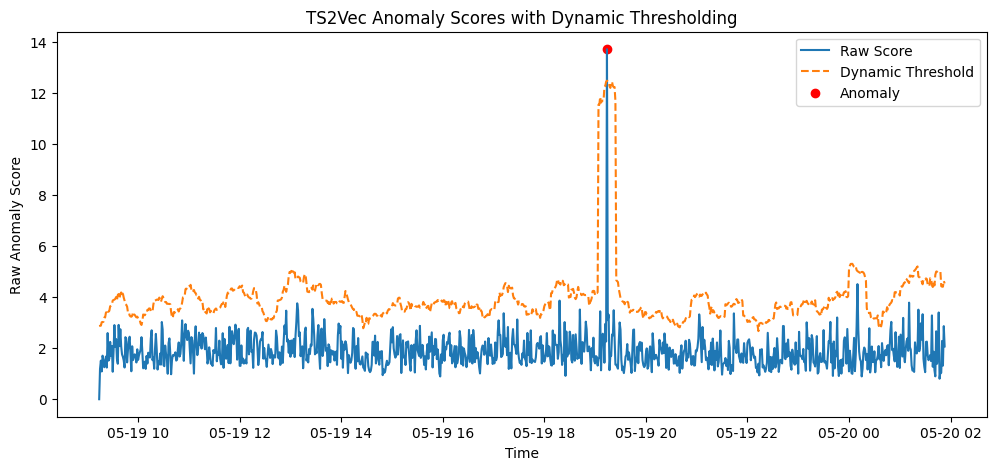

In [ ]:
raw_scores = get_anomaly_scores(model, data) # Pass the full scaled_data

is_anom_dyn, dyn_thresh = dynamic_threshold_median(
    raw_scores,
    window_size=20,   # you can tweak this
    z_thresh=4    # or 3, 2, depending on sensitivity
)

df['anomaly_score'] = raw_scores
df['is_anomaly_dynamic'] = is_anom_dyn
df['dyn_threshold'] = dyn_thresh

print("Dynamic‐threshold anomalies:")
print(df[df['is_anomaly_dynamic']])
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, raw_scores, label='Raw Score')
ax.plot(df.index, dyn_thresh, '--', label='Dynamic Threshold')
ax.scatter(df.index[is_anom_dyn],
           raw_scores[is_anom_dyn],
           color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('Raw Anomaly Score')
ax.legend()
plt.title("TS2Vec Anomaly Scores with Dynamic Thresholding")
plt.show()

## APPLYING TS2VEC ON LEVEL DOWN DATA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ts2vec import TS2Vec
import matplotlib.pyplot as plt

#loading the csv
df = pd.read_csv('system_metrics_shift_down_final.csv', parse_dates = ['Time'], index_col= 'Time')
print(df.head())

data = df[['CPU', 'Memory', 'Disk']].values
scaler = StandardScaler()
data = scaler.fit_transform(data)

T,D = data.shape

print(f"time stamps : {T}\n Feats = {D}")

                          CPU    Memory      Disk
Time                                             
2025-05-19 09:14:00  1.014901  2.069968  1.472993
2025-05-19 09:15:00  0.995852  2.046232  1.494219
2025-05-19 09:16:00  1.019431  2.002982  1.468303
2025-05-19 09:17:00  1.045691  1.967653  1.487682
2025-05-19 09:18:00  0.992975  2.034911  1.424255
time stamps : 1000
 Feats = 3


In [ ]:
train_ratio = 0.5
T = data.shape[0]

split_idx = int(T*train_ratio) # splitting the data at index 1000*0.5 i.e. timestap 500

train_data = data[:split_idx]
test_data = data[split_idx:]

train_data_3d = train_data.reshape(1,-1, data.shape[1])
test_data_3d = train_data.reshape(1,-1,data.shape[1]) # (1,-1, 3) batch_size , timestamps, features

In [ ]:
model = TS2Vec(input_dims = D, output_dims = 320, device = 'cuda')
model.fit(n_epochs = 800, verbose = True, train_data=train_data_3d)
print("model done fitting ")

Epoch #0: loss=2.969902515411377
Epoch #1: loss=2.318619966506958
Epoch #2: loss=2.1159796714782715
Epoch #3: loss=1.7878210544586182
Epoch #4: loss=1.7319177389144897
Epoch #5: loss=1.8935312032699585
Epoch #6: loss=1.4080578088760376
Epoch #7: loss=1.8412317037582397
Epoch #8: loss=1.7318036556243896
Epoch #9: loss=1.6569124460220337
Epoch #10: loss=1.6430577039718628
Epoch #11: loss=1.668064832687378
Epoch #12: loss=1.7373852729797363
Epoch #13: loss=1.7071131467819214
Epoch #14: loss=1.7131571769714355
Epoch #15: loss=1.1563973426818848
Epoch #16: loss=1.577790379524231
Epoch #17: loss=1.6895723342895508
Epoch #18: loss=1.632430076599121
Epoch #19: loss=1.466164231300354
Epoch #20: loss=1.8657232522964478
Epoch #21: loss=1.4738538265228271
Epoch #22: loss=1.6431902647018433
Epoch #23: loss=1.5820167064666748
Epoch #24: loss=1.6672146320343018
Epoch #25: loss=1.4717344045639038
Epoch #26: loss=1.517636775970459
Epoch #27: loss=1.81083345413208
Epoch #28: loss=1.654254674911499
Epoch

## Anomaly detectio block

- to fetch the encodings the dim needs to be ( batch_dim, num_timestamps, feats)

- hence post encoding we remove the batch_dim to get our original ( num_timestamps, feats) shaped data

In [ ]:
def get_anomaly_scores(ts2vec_model, data_to_score):
    """
    Calculates anomaly scores based on the TS2Vec paper

    """
    num_timesteps, num_features = data_to_score.shape
    data_input = data_to_score.reshape(1, num_timesteps, num_features)
    unmasked_embeddings_batch = ts2vec_model.encode(
        data_input,
        causal = True,
        sliding_length = None,
        sliding_padding = False
    )

    unmasked_embeddings = unmasked_embeddings_batch[0]

    emb_dim = unmasked_embeddings.shape[1]
    masked_embeddings = np.zeros((num_timesteps, emb_dim))

    if num_timesteps > 0:
        # For t=0 (first timestamp):
        # Set masked_embeddings[0] = unmasked_embeddings[0]. This results in S_0 = 0.
        masked_embeddings[0] = unmasked_embeddings[0]

    if num_timesteps > 1:
        # For t > 0: R(x_{<t}) is R(x_{<=t-1})
        # So, masked_embeddings[t] uses unmasked_embeddings[t-1]
        masked_embeddings[1:] = unmasked_embeddings[:-1]

    raw_scores = np.linalg.norm(unmasked_embeddings - masked_embeddings, ord=2, axis=1)

    return raw_scores

## dynamic threshold calculation

In [ ]:
from scipy.ndimage import median_filter
def dynamic_threshold_median(scores , window_size = 21, z_thresh = 3.0):
  local_median = median_filter(scores, size = window_size, mode = 'reflect')
  rolling_mean_for_std = np.convolve(scores, np.ones(window_size)/window_size, mode='same')
  rolling_std = np.sqrt(
        np.convolve((scores - rolling_mean_for_std)**2, np.ones(window_size)/window_size, mode='same')
    )
    # Prevent division by zero or tiny std issues by adding a small epsilon if std is very low
  rolling_std = np.maximum(rolling_std, 1e-8)
  threshold = local_median + z_thresh * rolling_std
  is_anomaly = scores > threshold

  return is_anomaly, threshold




Dynamic‐threshold anomalies:
                         CPU    Memory      Disk  anomaly_score  \
Time                                                              
2025-05-19 19:14:00  0.52271  0.990855  0.824938      16.542587   

                     is_anomaly_dynamic  dyn_threshold  
Time                                                    
2025-05-19 19:14:00                True      14.546633  


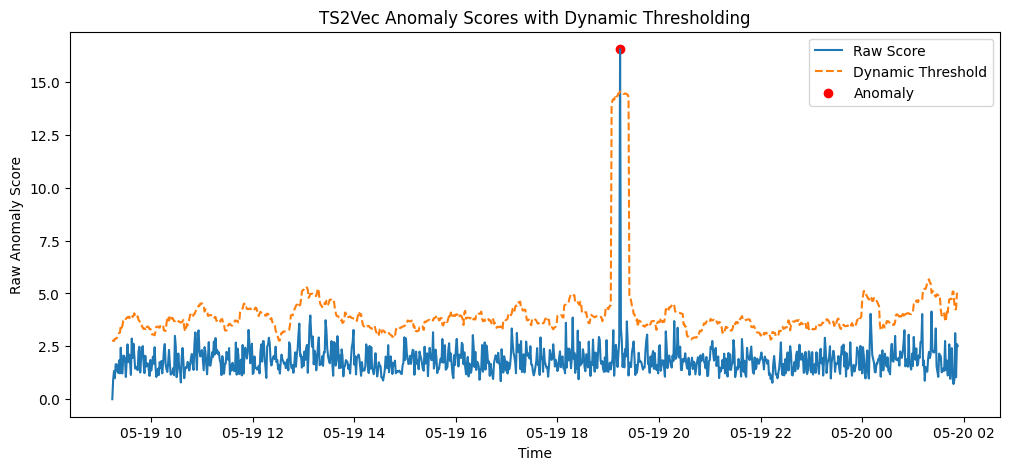

In [ ]:
raw_scores = get_anomaly_scores(model, data) # Pass the full scaled_data

is_anom_dyn, dyn_thresh = dynamic_threshold_median(
    raw_scores,
    window_size=21,   # you can tweak this
    z_thresh=4    # or 3, 2, depending on sensitivity
)

df['anomaly_score'] = raw_scores
df['is_anomaly_dynamic'] = is_anom_dyn
df['dyn_threshold'] = dyn_thresh

print("Dynamic‐threshold anomalies:")
print(df[df['is_anomaly_dynamic']])
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, raw_scores, label='Raw Score')
ax.plot(df.index, dyn_thresh, '--', label='Dynamic Threshold')
ax.scatter(df.index[is_anom_dyn],
           raw_scores[is_anom_dyn],
           color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('Raw Anomaly Score')
ax.legend()
plt.title("TS2Vec Anomaly Scores with Dynamic Thresholding")
plt.show()

In [ ]:
df

,CPU,Memory,Disk,anomaly_score,is_anomaly_dynamic,dyn_threshold
Time,,,,,,
2025-05-19 09:14:00,1.014901,2.069968,1.472993,0.000000,False,2.734152
2025-05-19 09:15:00,0.995852,2.046232,1.494219,0.914039,False,2.769265
2025-05-19 09:16:00,1.019431,2.002982,1.468303,1.331994,False,2.754184
2025-05-19 09:17:00,1.045691,1.967653,1.487682,0.992797,False,2.846920
2025-05-19 09:18:00,0.992975,2.034911,1.424255,1.647782,False,2.867485
...,...,...,...,...,...,...
2025-05-20 01:49:00,0.491567,1.053508,0.903099,0.921169,False,4.479556
2025-05-20 01:50:00,0.553931,0.998674,0.910310,3.122542,False,4.254908
2025-05-20 01:51:00,0.519225,0.955906,0.850330,1.039733,False,4.250878


#Working with Ramp up and Ramp down

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

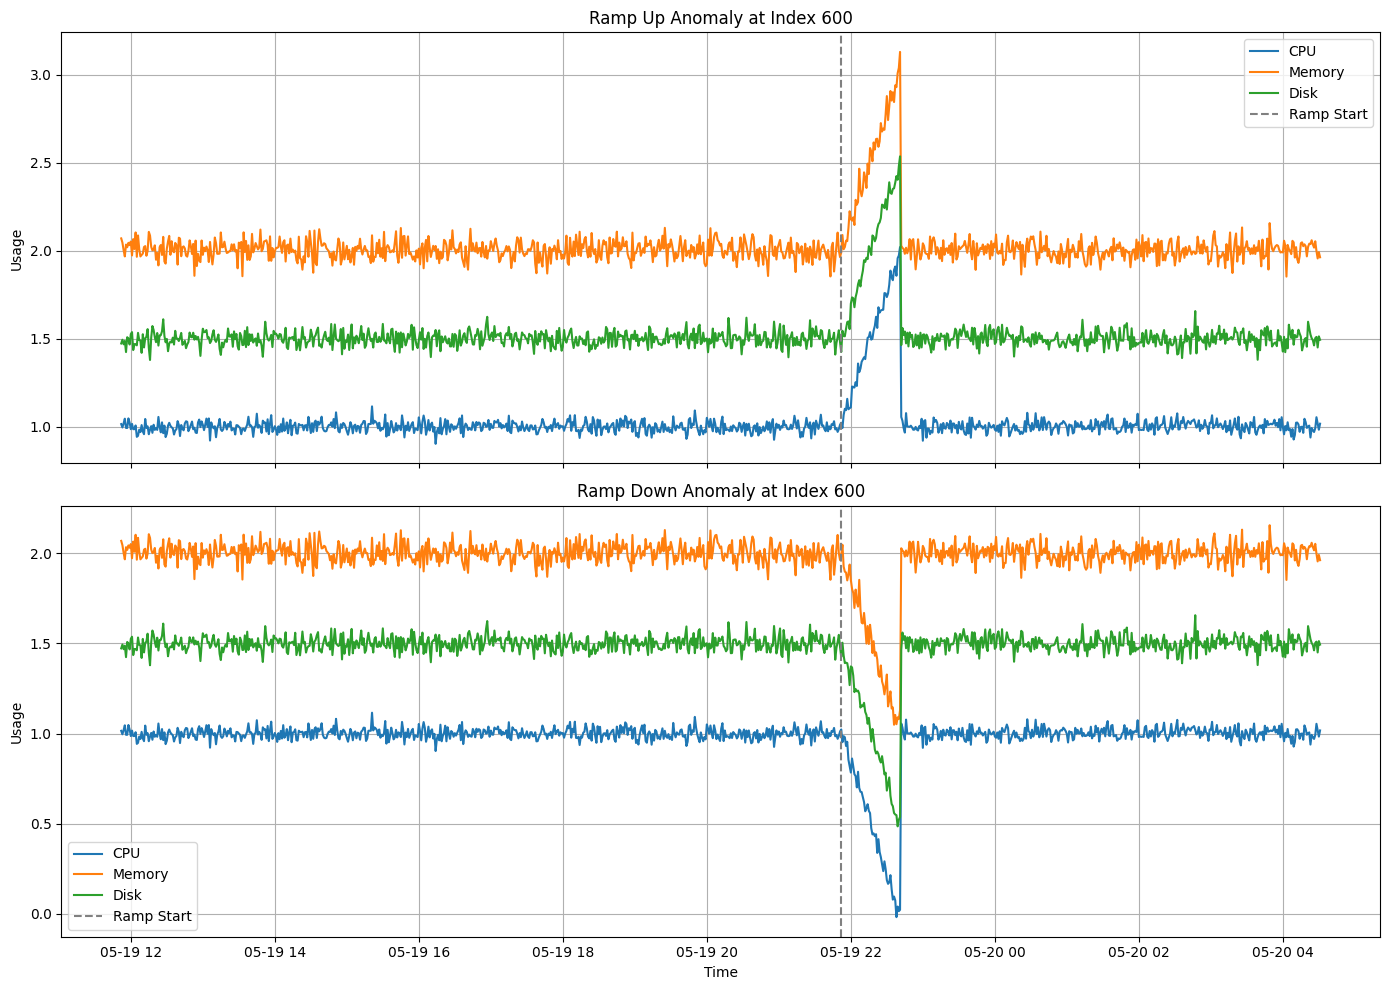

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the ramp datasets
df_up   = pd.read_csv('system_metrics_ramp_up.csv',   parse_dates=['Time'])
df_down = pd.read_csv('system_metrics_ramp_down.csv', parse_dates=['Time'])

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot ramp-up
axes[0].plot(df_up['Time'], df_up['CPU'],    label='CPU')
axes[0].plot(df_up['Time'], df_up['Memory'], label='Memory')
axes[0].plot(df_up['Time'], df_up['Disk'],   label='Disk')
axes[0].axvline(df_up['Time'].iloc[600], color='gray', linestyle='--', label='Ramp Start')
axes[0].set_title('Ramp Up Anomaly at Index 600')
axes[0].set_ylabel('Usage')
axes[0].legend()
axes[0].grid(True)

# Plot ramp-down
axes[1].plot(df_down['Time'], df_down['CPU'],    label='CPU')
axes[1].plot(df_down['Time'], df_down['Memory'], label='Memory')
axes[1].plot(df_down['Time'], df_down['Disk'],   label='Disk')
axes[1].axvline(df_down['Time'].iloc[600], color='gray', linestyle='--', label='Ramp Start')
axes[1].set_title('Ramp Down Anomaly at Index 600')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Usage')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
!pip install ts2vec

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ts2vec import TS2Vec
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv('system_metrics_ramp_down.csv', parse_dates=['Time'], index_col='Time')

# Visualize first few rows
print(df.head())

# Extract data values
data = df[['CPU', 'Memory', 'Disk']].values  # shape: (1000, 3)

# Normalize
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Get shapes
T, D = data.shape

                          CPU    Memory      Disk
Time                                             
2025-05-19 11:52:00  1.014901  2.069968  1.472993
2025-05-19 11:53:00  0.995852  2.046232  1.494219
2025-05-19 11:54:00  1.019431  2.002982  1.468303
2025-05-19 11:55:00  1.045691  1.967653  1.487682
2025-05-19 11:56:00  0.992975  2.034911  1.424255


In [ ]:
train_ratio = 0.5
T = data.shape[0]
split_idx = int(T*train_ratio)

train_data = data[:split_idx]
test_data = data[split_idx:]

train_data_3d = train_data.reshape(1, -1, data.shape[1])
test_data_3d = test_data.reshape(1,-1, data.shape[1])

In [ ]:
model = TS2Vec(input_dims=D, output_dims=320,device = 'cpu')
model.fit(train_data_3d, verbose=True, n_epochs = 800)
print("model fit on data")

Epoch #0: loss=2.2241733074188232
Epoch #1: loss=1.0314183235168457
Epoch #2: loss=1.6503667831420898
Epoch #3: loss=1.4538096189498901
Epoch #4: loss=1.822737216949463
Epoch #5: loss=1.3459070920944214
Epoch #6: loss=1.4999607801437378
Epoch #7: loss=1.702415943145752
Epoch #8: loss=1.8486177921295166
Epoch #9: loss=1.2112754583358765
Epoch #10: loss=1.6332893371582031
Epoch #11: loss=1.7116270065307617
Epoch #12: loss=1.6845821142196655
Epoch #13: loss=1.6262258291244507
Epoch #14: loss=0.8445402383804321
Epoch #15: loss=1.8399863243103027
Epoch #16: loss=1.6934552192687988
Epoch #17: loss=1.848925232887268
Epoch #18: loss=1.4315707683563232
Epoch #19: loss=1.79517662525177
Epoch #20: loss=0.6134251356124878
Epoch #21: loss=1.038394570350647
Epoch #22: loss=1.805235505104065
Epoch #23: loss=1.7327094078063965
Epoch #24: loss=1.509473443031311
Epoch #25: loss=1.5083868503570557
Epoch #26: loss=1.2263387441635132
Epoch #27: loss=1.657451868057251
Epoch #28: loss=1.4238805770874023
Epoc

In [ ]:
# Function to get masked and unmasked representations
def get_anomaly_scores(ts2vec_model, data_to_score):
    """
    Calculates anomaly scores based on the TS2Vec paper's method:
    S_t = ||R(x_{<=t}) - R(x_{<t})||_2.

    R(x_{<=t}) is the "unmasked" representation of data up to time t.
    R(x_{<t}) is the "masked" representation (data up to time t-1), approximated
    by R(x_{<=t-1}).

    Args:
        ts2vec_model: The trained TS2Vec model.
        data_to_score: A NumPy array of shape (num_timesteps, num_features)
                       or (1, num_timesteps, num_features).

    Returns:
        A NumPy array of raw anomaly scores, shape (num_timesteps,).
    """
    if data_to_score.ndim == 1: # Univariate series (T,)
        # Reshape to (num_timesteps, 1) to be treated as a feature.
        data_to_score = data_to_score.reshape(-1, 1)

    if data_to_score.ndim == 2: # Expected shape: (num_timesteps, num_features)
        num_timesteps, num_features = data_to_score.shape
        # Reshape to (1, num_timesteps, num_features) for the model.encode method
        data_input = data_to_score.reshape(1, num_timesteps, num_features)
    elif data_to_score.ndim == 3: # Expected shape: (1, num_timesteps, num_features)
        if data_to_score.shape[0] != 1:
            raise ValueError("If data_to_score is 3D, its first dimension (batch_size) must be 1.")
        data_input = data_to_score
        _, num_timesteps, num_features = data_input.shape # num_features is model.input_dims
    else:
        raise ValueError("Input data_to_score must be 2D (num_timesteps, num_features) or 3D (1, num_timesteps, num_features)")

    if num_timesteps == 0:
        return np.array([])

    # 1. Get Unmasked Embeddings: R(x_{<=t}) for each t
    # model.encode with causal=True and sliding_length=None gives prefix encodings.
    # Output shape from encode: (batch_size, num_timesteps, emb_dim)
    unmasked_embeddings_batch = ts2vec_model.encode(
        data_input,
        causal=True,
        sliding_length=None,  # This ensures R(x_{<=t}) for each t
        sliding_padding=False # Not relevant when sliding_length is None
    )
    # Remove batch dimension, final shape: (num_timesteps, emb_dim)
    unmasked_embeddings = unmasked_embeddings_batch[0]

    # 2. Get Masked Embeddings: R(x_{<t}) for each t
    # R(x_{<t}) is approximated by R(x_{<=t-1}).
    # For t=0, R(x_{<0}). To ensure S_0 = 0 (as in the example),
    # masked_embeddings[0] is set to unmasked_embeddings[0].
    emb_dim = unmasked_embeddings.shape[1]
    masked_embeddings = np.zeros((num_timesteps, emb_dim))

    if num_timesteps > 0:
        # For t=0 (first timestamp):
        # Set masked_embeddings[0] = unmasked_embeddings[0]. This results in S_0 = 0.
        masked_embeddings[0] = unmasked_embeddings[0]

    if num_timesteps > 1:
        # For t > 0: R(x_{<t}) is R(x_{<=t-1})
        # So, masked_embeddings[t] uses unmasked_embeddings[t-1]
        masked_embeddings[1:] = unmasked_embeddings[:-1]

    # 3. Calculate Raw Anomaly Scores
    # S_t = || unmasked_embedding_t - masked_embedding_t ||_2 (L2 norm)
    # This follows the TS2Vec paper and the provided example function.
    raw_scores = np.linalg.norm(unmasked_embeddings - masked_embeddings, ord=2, axis=1)

    return raw_scores


In [ ]:
from scipy.ndimage import median_filter
def dynamic_threshold_median(scores , window_size = 21, z_thresh = 3.0):
  local_median = median_filter(scores, size = window_size, mode = 'reflect')
  rolling_mean_for_std = np.convolve(scores, np.ones(window_size)/window_size, mode='same')
  rolling_std = np.sqrt(
        np.convolve((scores - rolling_mean_for_std)**2, np.ones(window_size)/window_size, mode='same')
    )
    # Prevent division by zero or tiny std issues by adding a small epsilon if std is very low
  rolling_std = np.maximum(rolling_std, 1e-8)
  threshold = local_median + z_thresh * rolling_std
  is_anomaly = scores > threshold

  return is_anomaly, threshold




Dynamic‐threshold anomalies:
                          CPU    Memory      Disk  anomaly_score  \
Time                                                               
2025-05-19 20:34:00  0.980121  1.988676  1.514699      13.010881   
2025-05-19 21:38:00  0.986219  2.008822  1.447230      12.970061   
2025-05-19 23:14:00  0.984264  1.954815  1.486822      11.880365   

                     is_anomaly_dynamic  dyn_threshold  
Time                                                    
2025-05-19 20:34:00                True      12.537626  
2025-05-19 21:38:00                True      12.968444  
2025-05-19 23:14:00                True      11.562983  


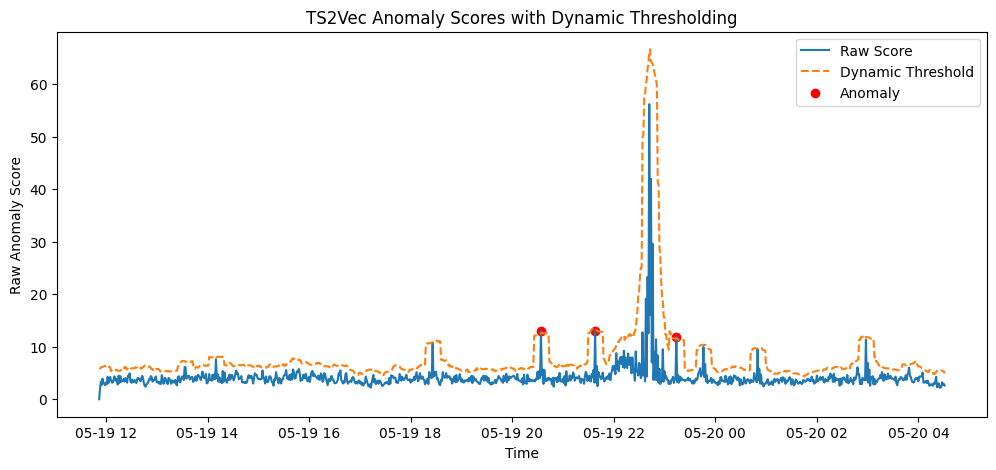

In [ ]:
raw_scores = get_anomaly_scores(model, data) # Pass the full scaled_data

is_anom_dyn, dyn_thresh = dynamic_threshold_median(
    raw_scores,
    window_size=18,   # you can tweak this
    z_thresh=4    # or 3, 2, depending on sensitivity
)

df['anomaly_score'] = raw_scores
df['is_anomaly_dynamic'] = is_anom_dyn
df['dyn_threshold'] = dyn_thresh

print("Dynamic‐threshold anomalies:")
print(df[df['is_anomaly_dynamic']])
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, raw_scores, label='Raw Score')
ax.plot(df.index, dyn_thresh, '--', label='Dynamic Threshold')
ax.scatter(df.index[is_anom_dyn],
           raw_scores[is_anom_dyn],
           color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('Raw Anomaly Score')
ax.legend()
plt.title("TS2Vec Anomaly Scores with Dynamic Thresholding")
plt.show()